In [1]:
# Import findspark to make possible for Python to locate the 
# spark executable using the SPARK_HOME environmental variable
import findspark
findspark.init()
# Print the location of the spark version we are using
print "Using: '" + findspark.find() + "'"

Using: '/Users/cvitter/spark-1.6.2'


In [2]:
# Import the Python API for Spark
import pyspark
from pyspark.sql import Row

In [3]:
# Setup the Spark configuration
conf = pyspark.SparkConf()
print conf.toDebugString()

spark.app.name=pyspark-shell
spark.master=local[*]
spark.submit.deployMode=client


In [5]:
# Pass the configuration to the Spark context
sc = pyspark.SparkContext(conf=conf)
sqlContext = pyspark.SQLContext(sc)

In [16]:
# The table to query, and the filter to apply to the query
table_name="aarhus"
query_filter = """
        ts > 1392290000000
        AND ts <  1402292200000
        AND status = 'OK'
        AND extid = '668'
""" % ({'start_date': start_date, 'end_date': end_date,})

# 
df = sqlContext.read \
    .format("org.apache.spark.sql.riak") \
    .option("spark.riak.connection.host", "127.0.0.1:8087") \
    .option("spark.riakts.bindings.timestamp", "useLong") \
    .load(table_name) \
    .filter(query_filter) 
    
# Output the fields and datatypes returned
df.printSchema()

# Output the first 20 rows of the dataset
df.show()

# Out count of records returned
df.count()

root
 |-- status: string (nullable = false)
 |-- extid: string (nullable = false)
 |-- ts: long (nullable = false)
 |-- avgMeasuredTime: long (nullable = false)
 |-- avgSpeed: long (nullable = false)
 |-- medianMeasuredTime: long (nullable = false)
 |-- vehicleCount: long (nullable = false)

+------+-----+-------------+---------------+--------+------------------+------------+
|status|extid|           ts|avgMeasuredTime|avgSpeed|medianMeasuredTime|vehicleCount|
+------+-----+-------------+---------------+--------+------------------+------------+
|    OK|  668|1392291000000|             66|      56|                66|           7|
|    OK|  668|1392291300000|             69|      53|                69|           5|
|    OK|  668|1392291600000|             69|      53|                69|           6|
|    OK|  668|1392291900000|             70|      52|                70|           3|
|    OK|  668|1392292200000|             64|      57|                64|           6|
|    OK|  668|13922

32059

In [20]:
# Filter out all but the ts and vehicle count columns into rdd1 (the operation of filtering
# returns an RDD from the Dataframe)
rdd1 = df['ts','vehicleCount']
rdd1.show()

+-------------+------------+
|           ts|vehicleCount|
+-------------+------------+
|1392291000000|           7|
|1392291300000|           5|
|1392291600000|           6|
|1392291900000|           3|
|1392292200000|           6|
|1392292500000|           9|
|1392292800000|          11|
|1392293100000|           8|
|1392293400000|          10|
|1392293700000|          12|
|1392294000000|          16|
|1392294300000|          16|
|1392294600000|           8|
|1392294900000|           9|
|1392295200000|           8|
|1392295500000|           7|
|1392295800000|          11|
|1392296100000|           8|
|1392296400000|           8|
|1392296700000|           9|
+-------------+------------+
only showing top 20 rows



In [28]:
# Import datetime and create a method that converts the timestamp
# to the day of the week (1 - 7)
from datetime import datetime
def getDOW(row):
    dt = datetime.fromtimestamp(row[0]/1000)
    dow = dt.isoweekday()
    return Row(dow, row[1])

# Create rdd2 mapping the date values in rdd1 with the getDOW function
rdd2 = rdd1.map(getDOW)

# Convert the RDD to a Dataframe
df2 = rdd2.toDF()

# Perform a group by on the day of the week to get a count for each
summary = df2.groupBy('_1').sum().collect()

# Print out the days of the week with their respective counts
for r in summary:
    print r[0],r[2]

1 24015
2 25442
3 24672
4 23556
5 22627
6 9465
7 8265


In [29]:
import matplotlib as plt
import pandas as pd
%matplotlib inline

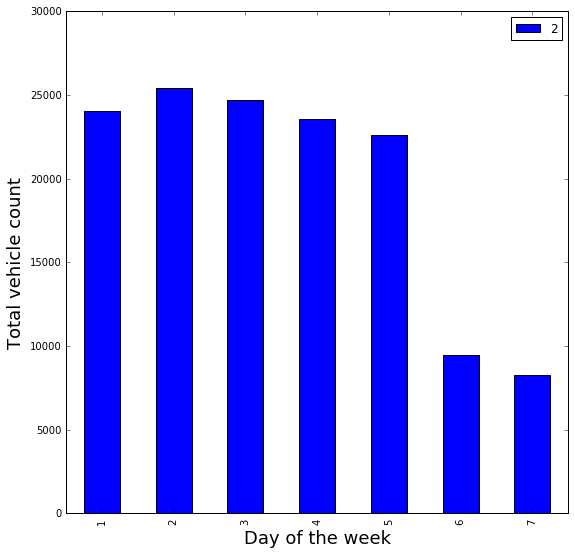

In [30]:
# Convert the summary Dataframe to a Pandas Dataframe and
# Visualize the data using matplotlib
tdf = pd.DataFrame(summary)
tdf.describe()
ax=tdf.plot(x=0,y=2,figsize=(9,9),kind='bar')
ax.set_ylabel('Total vehicle count', fontsize=18)
ax.set_xlabel('Day of the week', fontsize=18)